In [1]:
library(susieR)
library(RcppCNPy)
library(ggplot2)
library(dplyr)
library(tibble)
library(readr)
library(patchwork)
library(stringr)

options(repr.plot.width=8, repr.plot.height=8)
theme_set(theme_classic(base_size=13))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
ROOT_DIR = "/u/project/pasaniuc/kangchen/h2gene/analysis/simulation/out"
ESTIMATE_DIR <- file.path(ROOT_DIR, "estimate")

In [137]:
prefix <- '50_0.001_5_3'
df_summary <- read_tsv(file.path(ESTIMATE_DIR, prefix, "summary.tsv"))


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  NAME = col_character()
)
ℹ Use `spec()` for the full column specifications.




In [138]:
maf_bin <- "ALL"

In [139]:
rename_list <- c(NAME="NAME",
                SIM_I="SIM_I", 
                TRUE_VAR=paste0(maf_bin, '_TRUE_VAR'),
                MEAN=paste0(maf_bin, '_MEAN'),
                SD=paste0(maf_bin, '_SD'))
estimates <- df_summary %>% select(!!rename_list)

In [140]:
# cumulative distribution
estimate_df <- tibble()
for (sim_i in 1 : 30){
    df <- estimates %>% filter(SIM_I == sim_i) %>% arrange(desc(MEAN))
    df$RANK <- 1 : nrow(df)
    df$CUM_PROP <- cumsum(df$MEAN) / sum(df$MEAN)
    estimate_df <- bind_rows(estimate_df, df)

}

true_df <- tibble(RANK=1:nrow(df),
                   CUM_PROP=cumsum(sort(df$TRUE_VAR, decreasing = TRUE)) / sum(df$TRUE_VAR))

n_causal_gene <- sum(true_df$CUM_PROP < 1) + 1
estimate_df <- estimate_df %>% filter(RANK < n_causal_gene * 1.5, SIM_I < 10)
true_df <- true_df %>% filter(RANK < n_causal_gene * 1.5)
# p2 <- ggplot(estimate_df, aes(x=RANK, y=CUM_PROP, color=as.factor(SIM_I))) + 
#     geom_step(alpha=0.5) +
#     geom_step(data=optimal_df, alpha=0.5, color='black') + 
#     xlab('Estimated rank') + ylab('Cumulative proportion') + 
#     labs(title=maf_bin) + 
#     theme(legend.position = "none")

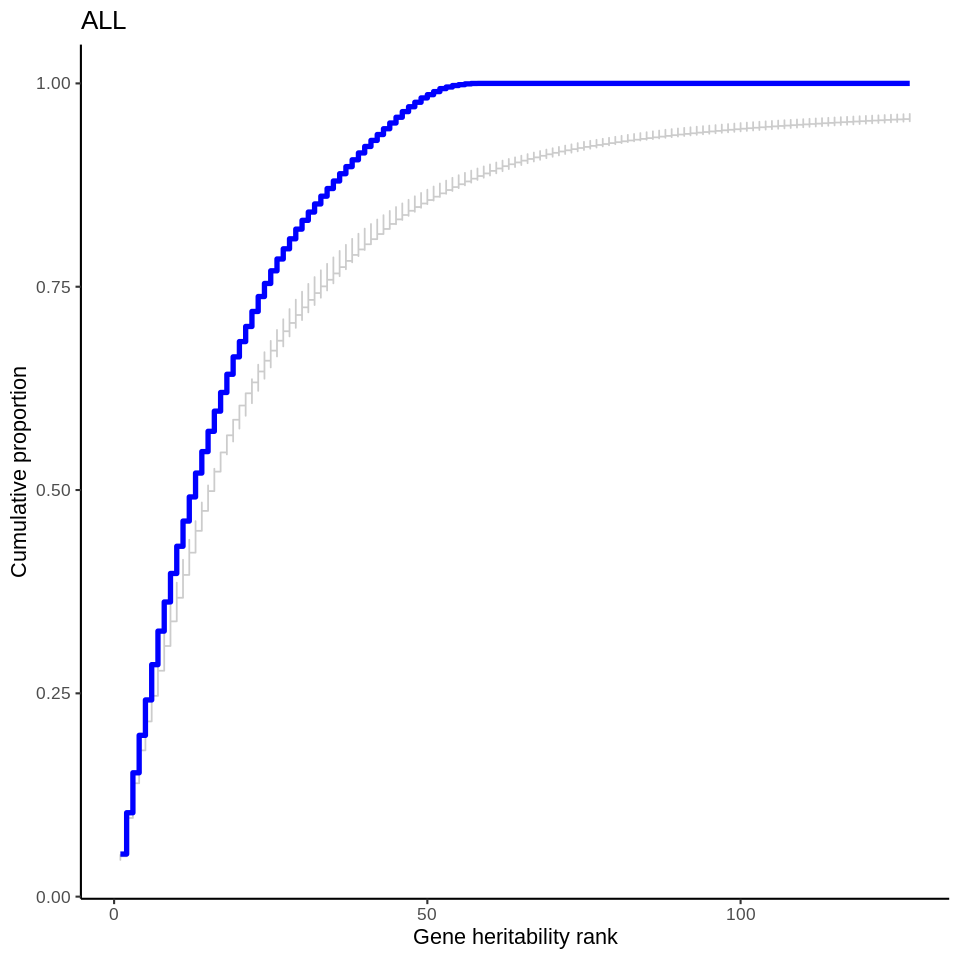

In [143]:
ggplot(estimate_df, aes(x=RANK, y=CUM_PROP)) + geom_step(alpha=0.2, color="black") +
    geom_step(data=true_df, alpha=1, color='blue', size=1.5) + 
    xlab('Gene heritability rank') + ylab('Cumulative proportion') + 
    labs(title=maf_bin) + 
    theme(legend.position = "none")

In [46]:
# x-axis: number of genes (ordered by estimated heritability / true heritability)
# y-axis: explained fraction of heritabilty